**Evaluating strategy built from Regression model**

In [1]:
import statsmodels.formula.api as smf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
indicepanel = pd.read_csv('C:/Users/Usuario/Desktop/proyectos/Analisis_Financiero_1/Datasets/indicepanel2.csv', index_col=0, parse_dates=True)
indicepanel.head()

,spy,spy_lag1,MSCI,SPDR,EZU,EWJ,QQQ,sp500,dji,nasdaq,Price
Fecha,,,,,,,,,,,
2021-01-05,7.21,-1.61,-0.62,-0.70,-0.23,0.07,4.86,-14.2,-158.53,-0.50,368.10
2021-01-06,-1.61,-6.39,-0.61,-1.18,-0.04,0.31,-2.74,-52.5,-538.40,-201.19,369.71
2021-01-07,-6.39,-4.49,-0.74,-0.14,-0.17,-1.10,-2.36,-50.4,-168.40,-292.88,376.10
2021-01-08,-4.49,2.74,0.94,0.47,0.98,0.88,3.05,12.0,54.21,111.44,380.59
2021-01-11,2.74,-1.04,0.11,-0.58,0.06,0.07,-0.04,1.5,0.36,-13.28,377.85


In [5]:
indicepanel.index

DatetimeIndex(['2021-01-05', '2021-01-06', '2021-01-07', '2021-01-08',
               '2021-01-11', '2021-01-12', '2021-01-13', '2021-01-14',
               '2021-01-15', '2021-01-19',
               ...
               '2025-02-27', '2025-02-28', '2025-03-03', '2025-03-04',
               '2025-03-05', '2025-03-06', '2025-03-07', '2025-03-10',
               '2025-03-11', '2025-03-12'],
              dtype='datetime64[ns]', name='Fecha', length=1056, freq=None)

In [6]:
# split the data into (1)train set and (2)test set
Train = indicepanel.iloc[0:500,:]
Test = indicepanel.iloc[500:1000,:]

In [7]:
formula = 'spy~spy_lag1+sp500+nasdaq+dji+MSCI+SPDR+EZU+EWJ+QQQ' #[MSCI, SPDR, EZU, EWJ, QQQ, sp500, dji, nasdaq, spy]
lm = smf.ols(formula=formula, data=Train).fit()

In [8]:
Train['PredictedY'] = lm.predict(Train)
Test['PredictedY'] = lm.predict(Test)

# Profit of Signal-based strategy

#### Uso de la Predicción como Señal de Trading

Con la predicción del cambio de precio de SPY, se diseñó una estrategia de trading simple:

1. Si la predicción del cambio de precio es positiva, tomamos una **posición larga** (compramos una acción de SPY).
2. Si la predicción del cambio de precio es negativa, tomamos una **posición corta** (vendemos en corto una acción de SPY).

Matemáticamente, la orden de compra/venta se define como:

$$ \text{Orden}(t) = \begin{cases} 
1, & \text{si } \hat{y}(t) > 0 \\
-1, & \text{si } \hat{y}(t) \leq 0
\end{cases} $$

donde $\hat{y}(t)$ es la predicción del cambio de precio.


#### Cálculo de Ganancia Diaria y Riqueza Acumulada

La ganancia diaria se calcula como:

$$ \text{Ganancia}(t) = \text{Orden}(t-1) \times (P_{open}(t) - P_{open}(t-1)) $$

donde $P_{open}(t)$ es el precio de apertura en el día $t$.

La riqueza acumulada se obtiene sumando las ganancias diarias:

$$ \text{Riqueza}(t) = \sum_{i=1}^{t} \text{Ganancia}(i) $$

# Train

In [9]:
# Crea columna que indica si se debe comprar (1) o vender (-1) basado en la predicción.
Train['Order'] = [1 if sig>0 else -1 for sig in Train['PredictedY']]

#Calcula el beneficio diario multiplicando el rendimiento de spy por la señal de compra/venta.
Train['Profit'] = Train['spy'] * Train['Order']

#Calcula la riqueza acumulada a lo largo del tiempo.
Train['Wealth'] = Train['Profit'].cumsum()

#Suma todos los beneficios para obtener el beneficio total.
print('Total profit made in Train: ', Train['Profit'].sum())

Total profit made in Train:  930.3600000000006


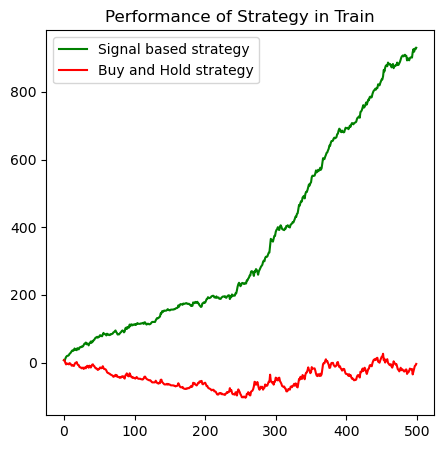

In [10]:
#Visualización de Resultados
plt.figure(figsize=(5, 5))
plt.title('Performance of Strategy in Train') # riqueza acumulada a lo largo del tiempo.
plt.plot(Train['Wealth'].values, color='green', label='Signal based strategy')
plt.plot(Train['spy'].cumsum().values, color='red', label='Buy and Hold strategy')
plt.legend()
plt.show()

# Test

In [11]:

Test['Order'] = [1 if sig>0 else -1 for sig in Test['PredictedY']]
Test['Profit'] = Test['spy'] * Test['Order']

Test['Wealth'] = Test['Profit'].cumsum()
print('Total profit made in Test: ', Test['Profit'].sum())

Total profit made in Test:  469.19999999999936


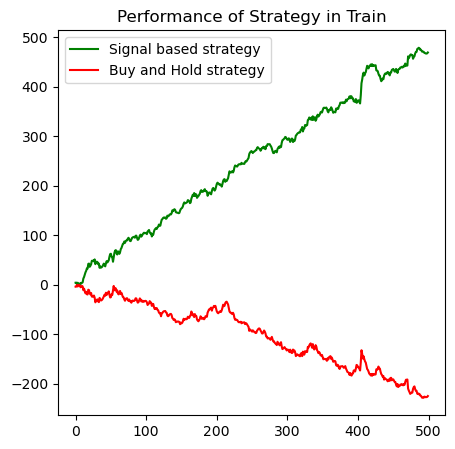

In [12]:
plt.figure(figsize=(5, 5))
plt.title('Performance of Strategy in Train')
plt.plot(Test['Wealth'].values, color='green', label='Signal based strategy')
plt.plot(Test['spy'].cumsum().values, color='red', label='Buy and Hold strategy')
plt.legend()
plt.show()

**Análisis**

La estrategia de comprar y mantener no es buena en este caso porque el mercado ha tenido un rendimiento negativo, y esta estrategia no ha podido evitar las pérdidas.

La estrategia basada en señales es mejor en este caso, ya que ha mitigado las pérdidas al tomar decisiones activas basadas en las predicciones del modelo.

# Evaluation of model - Practical Standard

We introduce two common practical standards - **Sharpe Ratio**, **Maximum Drawdown** to evaluate our model performance


In [13]:
Train['Wealth'] = Train['Wealth'] + Train.loc[Train.index[0], 'Price']
Test['Wealth'] = Test['Wealth'] + Test.loc[Test.index[0], 'Price']

### Sharpe Ratio

El **ratio de Sharpe** mide el exceso de retorno por unidad de desviación estándar y se define como:

$$ S = \frac{\mathbb{E}[r - r_f]}{\sigma} $$

donde:
- $r$ es el retorno de la estrategia,
- $r_f$ es la tasa libre de riesgo,
- $\sigma$ es la desviación estándar de los retornos.

El ratio de Sharpe diario se convierte a anual mediante:

$$ S_{anual} = S_{diario} \times \sqrt{252} $$



**Interpretación del Ratio de Sharpe:**

**-Ratio de Sharpe positivo**: Indica que la inversión está generando un rendimiento superior a la tasa libre de riesgo (como los bonos del gobierno) por unidad de riesgo. Cuanto más alto sea el Ratio de Sharpe, mejor es el rendimiento ajustado al riesgo.

**-Ratio de Sharpe negativo**: Indica que la inversión está generando un rendimiento inferior a la tasa libre de riesgo. Esto sugiere que la inversión no está compensando adecuadamente el riesgo asumido.

In [14]:
# Sharpe Ratio on Train data
Train['Return'] = np.log(Train['Wealth']) - np.log(Train['Wealth'].shift(1))
dailyr = Train['Return'].dropna()

print('Daily Sharpe Ratio is ', dailyr.mean()/dailyr.std(ddof=1))
print('Yearly Sharpe Ratio is ', (252**0.5)*dailyr.mean()/dailyr.std(ddof=1))

Daily Sharpe Ratio is  0.38977777627719545
Yearly Sharpe Ratio is  6.187530375655384


In [15]:
# Sharpe Ratio in Test data
Test['Return'] = np.log(Test['Wealth']) - np.log(Test['Wealth'].shift(1))
dailyr = Test['Return'].dropna()

print('Daily Sharpe Ratio is ', dailyr.mean()/dailyr.std(ddof=1))
print('Yearly Sharpe Ratio is ', (252**0.5)*dailyr.mean()/dailyr.std(ddof=1))

Daily Sharpe Ratio is  0.2515169292138986
Yearly Sharpe Ratio is  3.992707471335673


Se puede decir que el rendimiento de la inversión es muy bueno

### Maximum Drawdown 


El **Maximum Drawdown (MDD)**: Mide la mayor caída porcentual desde el pico máximo hasta el valle más bajo en el valor de una cartera o inversión antes de que se recupere a un nuevo pico: 

$$ \text{Drawdown}(t) = \frac{\text{Riqueza}(t) - \max_{s \leq t} \text{Riqueza}(s)}{\max_{s \leq t} \text{Riqueza}(s)} $$

El MDD es el máximo drawdown observado en el periodo de trading.

[0-100] Siendo valores cercanos a "0" un indicador bueno con perdidas mínimas



In [16]:
# Maximum Drawdown in Train data
Train['Peak'] = Train['Wealth'].cummax()
Train['Drawdown'] = (Train['Peak'] - Train['Wealth'])/Train['Peak']
print('Maximum Drawdown in Train is ', Train['Drawdown'].max())

Maximum Drawdown in Train is  0.027657088612216538


In [17]:
# Maximum Drawdown in Test data
Test['Peak'] = Test['Wealth'].cummax()
Test['Drawdown'] = (Test['Peak'] - Test['Wealth'])/Test['Peak']
print('Maximum Drawdown in Test is ', Test['Drawdown'].max())

Maximum Drawdown in Test is  0.04147159611950385


Estos resultados indican que la estrategia mantiene consistencia en términos de riesgo de pérdidas extremas, aunque el retorno por unidad de riesgo no es completamente estable.